In [1]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np

## Hacemos las pruebas de todas las posibles STD (acotado entre 1 y 2), para hallar la más optimo para un determinado índice

C:\Users\pable\AppData\Local\Temp\ipykernel_23436\2138605139.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download([ticker, cash_ticker], period="max")['Close'].ffill()
[*********************100%***********************]  2 of 2 completed


Optimal standard deviation: 1.33 with final return: 53.9570


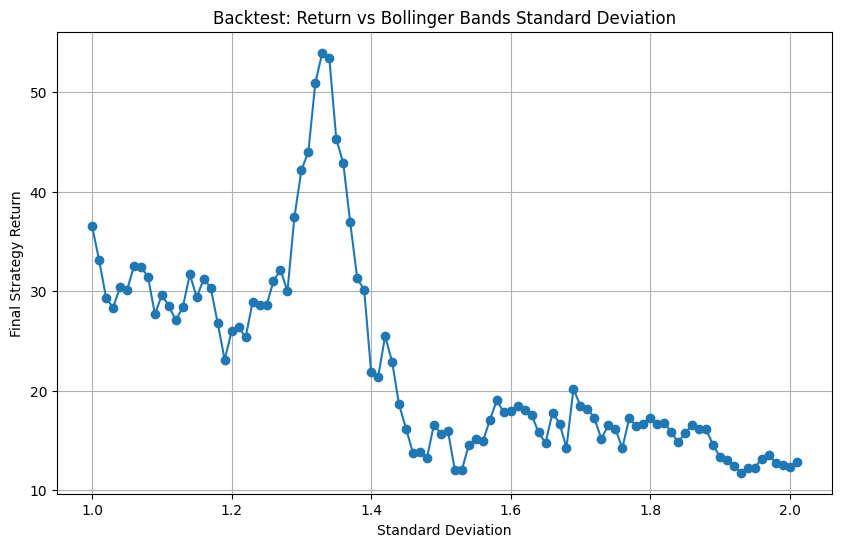

In [ ]:
# Parámetros iniciales
BB_LEN = 8
LOOKBACK = 10000
TICKER = 'SPY'
CASH_TICKER = 'GC=F'

# Funciones que ya tenías
def get_data(ticker = TICKER, cash_ticker=CASH_TICKER, lookback = LOOKBACK):
    df = yf.download([ticker, cash_ticker], period="max")['Close'].ffill()
    df.columns = df.columns.get_level_values(0)
    return df.iloc[-lookback:, :]

def add_bollinger_bands(df, ticker=TICKER, std=1, bb_len=BB_LEN):
    df['BB_SMA'] = df[ticker].rolling(bb_len).mean()
    df['BB_STD'] = df[ticker].rolling(bb_len).std()
    df['Upper_Band'] = df['BB_SMA'] + (std * df['BB_STD'])
    df['Lower_Band'] = df['BB_SMA'] - (std * df['BB_STD'])
    return df.dropna()

def add_strategy(df, ticker=TICKER):
    df['Strategy'] = np.where(
        df[ticker] > df['Upper_Band'], -1, 
        np.where(df[ticker] < df['Lower_Band'], 1, 0)
    )
    df['Strategy'] = df['Strategy'].shift(1).fillna(0)
    return df

def test_strategy(df, ticker=TICKER, cash_ticker=CASH_TICKER):
    asset_ret = df[ticker].pct_change().fillna(0)
    cash_ret  = df[cash_ticker].pct_change().fillna(0)
    strat_daily = np.where(
        df['Strategy'] == 0,
        cash_ret,
        df['Strategy'] * asset_ret
    )
    df['Strategy_Returns'] = (1 + strat_daily).cumprod() - 1
    return df['Strategy_Returns'].iloc[-1]  # Retorno final

# Descargar datos
df = get_data()

# Probar desviaciones de 1 a 2 con salto de 0.02
std_values = np.arange(1, 2.02, 0.01)
results = []

for std in std_values:
    df_temp = add_bollinger_bands(df.copy(), std=std)
    df_temp = add_strategy(df_temp)
    final_return = test_strategy(df_temp)
    results.append(final_return)

# Mostrar resultados
best_std = std_values[np.argmax(results)]
print(f"Optimal standard deviation: {best_std:.2f} with final return: {max(results):.4f}")

# Graficar
plt.figure(figsize=(10, 6))
plt.plot(std_values, results, marker='o')
plt.xlabel("Standard Deviation")
plt.ylabel("Final Strategy Return")
plt.title("Backtest: Return vs Bollinger Bands Standard Deviation")
plt.grid(True)
plt.show()


## Probamos dicha STD para ver las ganancias anuales

C:\Users\pable\AppData\Local\Temp\ipykernel_23436\2178750437.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download([ticker, cash_ticker], period="max")['Close'].ffill()
[*********************100%***********************]  2 of 2 completed


Annualized return of SPY: 8.07%
Annualized return of strategy: 17.33%


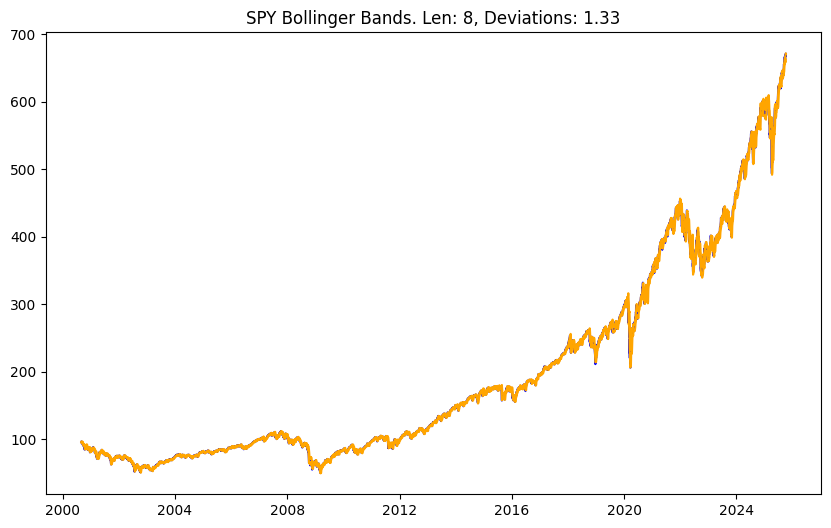

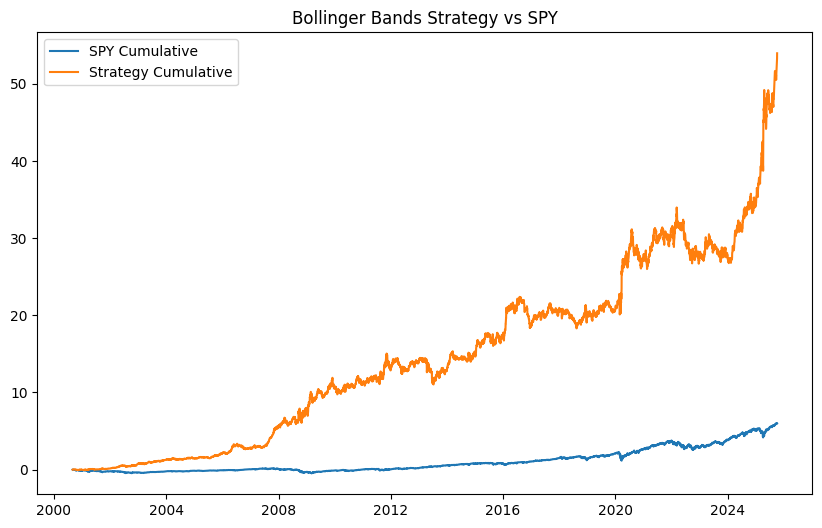

In [32]:
BB_LEN = 8
STD = 1.33
LOOKBACK = 10000
TICKER = 'SPY'
CASH_TICKER = 'GC=F'

def get_data(ticker = TICKER, cash_ticker=CASH_TICKER, lookback = LOOKBACK):
    df = yf.download([ticker, cash_ticker], period="max")['Close'].ffill()
    df.columns = df.columns.get_level_values(0)
    return df.iloc[-lookback:, :]

def add_bollinger_bands(df, ticker=TICKER, std=STD, bb_len=BB_LEN):
    df['BB_SMA'] = df[ticker].rolling(bb_len).mean()
    df['BB_STD'] = df[ticker].rolling(bb_len).std()

    df['Upper_Band'] = df['BB_SMA'] + (std * df['BB_STD'])
    df['Lower_Band'] = df['BB_SMA'] - (std * df['BB_STD'])

    df = df.dropna()

    plt.figure(figsize=(10, 6))
    plt.plot(df[ticker], color='blue')
    plt.plot(df['Upper_Band'], color='orange')
    plt.plot(df['Lower_Band'], color='orange')

    plt.title(f'{TICKER} Bollinger Bands. Len: {BB_LEN}, Deviations: {STD}')

    return df

def add_strategy(df, ticker=TICKER):
    df['Strategy'] = np.where(
        df[ticker] > df['Upper_Band'], -1, 
        np.where(df[ticker] < df['Lower_Band'], 1, 0)
    )
    df['Strategy'] = df['Strategy'].shift(1).fillna(0)
    
    return df

def test_strategy_with_annual_return(df, ticker=TICKER, cash_ticker=CASH_TICKER):
    asset_ret = df[ticker].pct_change().fillna(0)
    cash_ret  = df[cash_ticker].pct_change().fillna(0)

    strat_daily = np.where(
        df['Strategy'] == 0,
        cash_ret,
        df['Strategy'] * asset_ret
    )

    df['Asset_Returns']    = (1 + asset_ret).cumprod() - 1
    df['Strategy_Returns'] = (1 + strat_daily).cumprod() - 1

    N = len(df)
    annual_asset_return = (1 + df['Asset_Returns'].iloc[-1])**(252/N) - 1
    annual_strategy_return = (1 + df['Strategy_Returns'].iloc[-1])**(252/N) - 1

    plt.figure(figsize=(10, 6))
    plt.plot(df['Asset_Returns'], label=f'{ticker} Cumulative')
    plt.plot(df['Strategy_Returns'], label='Strategy Cumulative')
    plt.legend()
    plt.title(f'Bollinger Bands Strategy vs {ticker}')

    print(f"Annualized return of {ticker}: {annual_asset_return*100:.2f}%")
    print(f"Annualized return of strategy: {annual_strategy_return*100:.2f}%")

    return df




def test_strategy(df, ticker=TICKER, cash_ticker=CASH_TICKER):
    asset_ret = df[ticker].pct_change().fillna(0)
    cash_ret  = df[cash_ticker].pct_change().fillna(0)

    strat_daily = np.where(
        df['Strategy'] == 0,
        cash_ret,
        df['Strategy'] * asset_ret
    )

    df['Asset_Returns']    = (1 + asset_ret).cumprod() - 1
    df['Strategy_Returns'] = (1 + strat_daily).cumprod() - 1

    plt.figure(figsize=(10, 6))
    plt.plot(df['Asset_Returns'], label=f'{TICKER} Cumulative')
    plt.plot(df['Strategy_Returns'], label='Strategy Cumulative')
    plt.legend()
    plt.title(F'Bollinger Bands Strategy vs {TICKER}')

    return df


def main():
    df = get_data()
    df = add_bollinger_bands(df)
    df = add_strategy(df)
    df = test_strategy_with_annual_return(df)

    return df

df = main()